<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
mod  = test.index % 5
test_add = test.loc[ mod != 0 ,:]
test_50 = test.loc[ mod == 0 ,:]
train = train.append(test_add)
test = test_50
print(train.shape)
print(test.shape)

(4721, 27)
(50, 27)


In [0]:
y_name = 'C8A'

# C8A與原始特徵相關係數

In [4]:
train.iloc[:,:4].join(train[y_name]).corr().loc[[y_name]]

,T10,T50,T90,N+A,C8A
C8A,0.374473,0.396114,0.069561,0.041365,1.0


# C8A與其他Y相關係數

In [5]:
corr_res = abs(train.iloc[:,4:].corr())[[y_name]].sort_values(by=y_name,ascending=False)
corr_res.head(5).T

,C8A,C9A,C5NP,C6IP,C5IP
C8A,1.0,0.544554,0.425744,0.409445,0.394207


# def features & y_columns

In [6]:
features = ['T10','T50','T90','N+A']
y_columns = list(corr_res[corr_res[y_name]>0.8].index)
print(features)
print(y_columns)

['T10', 'T50', 'T90', 'N+A']
['C8A']


# scaler features

In [0]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()

train[features] = scaler_x.fit_transform(train[features])
test[features] = scaler_x.transform(test[features])

# corr

In [8]:
train[features+[y_name]].corr()

,T10,T50,T90,N+A,C8A
T10,1.000000,0.895238,0.222087,-0.262210,0.438734
T50,0.895238,1.000000,0.533778,-0.371996,0.464433
T90,0.222087,0.533778,1.000000,-0.217989,0.083671
N+A,-0.262210,-0.371996,-0.217989,1.000000,0.039550
C8A,0.438734,0.464433,0.083671,0.039550,1.000000


# scatter

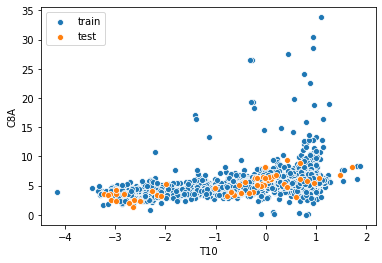

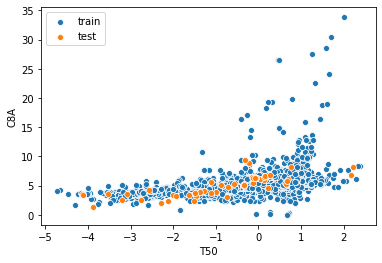

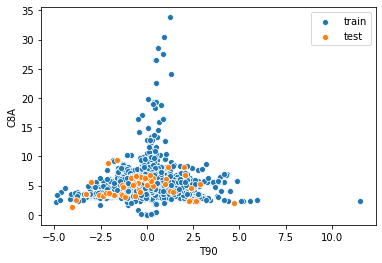

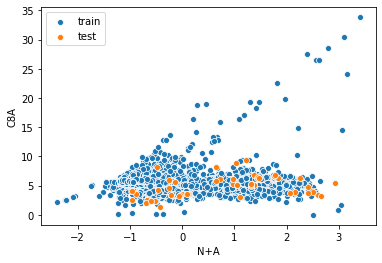

In [9]:
for x_col in features:
  sns.scatterplot(x=x_col,y=y_name,data=train,label='train')
  sns.scatterplot(x=x_col,y=y_name,data=test,label='test')
  plt.legend()
  plt.show()

# features select

In [0]:
features = ['T50']

# features scaling

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[features].append(test[features]))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

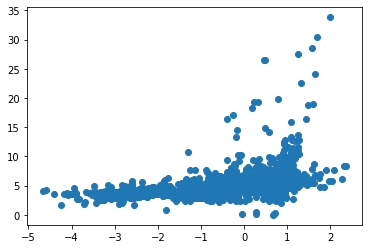

In [13]:
plt.scatter(train['T50'],train[y_name])

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[y_t.name])

# modeling

In [15]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression,ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

#model = DecisionTreeRegressor(max_depth=1)
#model = xgboost.XGBRegressor(objective='reg:squarederror')
model = SVR()
#model = LinearRegression()
#model = ridge.Ridge()
#model = Lasso(alpha=0.01)

val_scores = cross_validate(model,train[features],train[y_name],cv=5)

print('val_scores:',val_scores['test_score'])
print('val_scores.mean:',val_scores['test_score'].mean())

# fit 
model.fit(train[features],train[y_name])
# predict
test['y_pred'] = model.predict(test[features])
train['y_pred'] = model.predict(train[features])

val_scores: [0.3627187  0.22709151 0.16567673 0.06809147 0.11335874]
val_scores.mean: 0.18738742883076265


In [16]:
print('train_scores:')
metric(train[y_name],train['y_pred'])

train_scores:


,R2,RMSE,mean_absolute_error
C8A,0.20894,1.402871,0.583316


In [17]:
print('test_scores:')
metric(test[y_name],test['y_pred'])

test_scores:


,R2,RMSE,mean_absolute_error
C8A,0.560318,1.182411,0.818223


# line plot

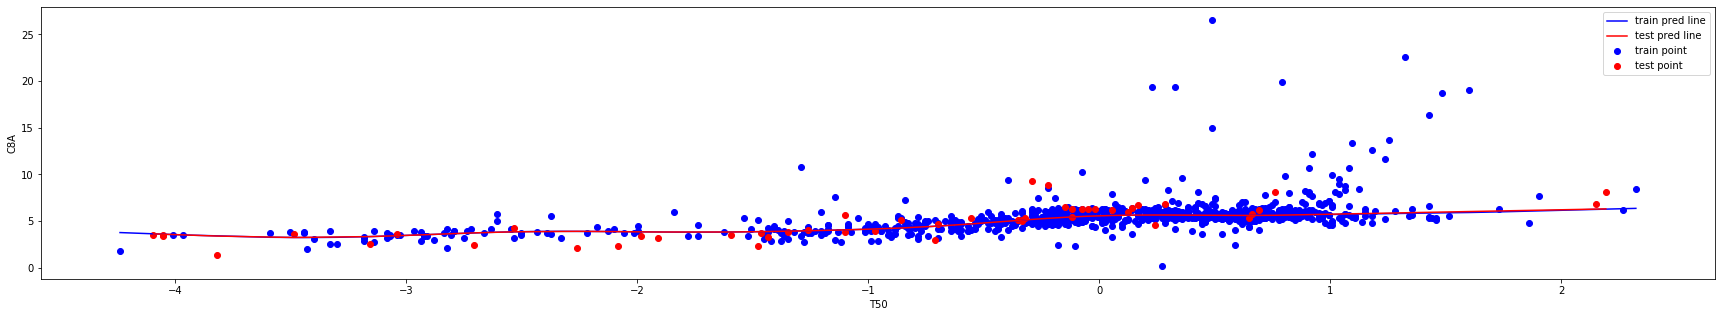

In [18]:
by_col = 'T50'
fig = plt.figure(figsize=(30,5))
test_point = test.sort_values(by = by_col)
train_sample_point = train.sample(1000).sort_values(by = by_col)

plt.plot(train_sample_point[by_col],train_sample_point['y_pred'],label='train pred line',color='blue')
plt.scatter(train_sample_point[by_col],train_sample_point[y_name],label='train point',color='blue')

plt.plot(test_point[by_col],test_point['y_pred'],label='test pred line',color='red')
plt.scatter(test_point[by_col],test_point[y_name],label='test point',color='red')

plt.xlabel(by_col)
plt.ylabel(y_name)
plt.legend()
plt.show()

# check out

In [19]:
loss = (test_point[y_name] - test_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)
loss.head(5)

240    17.009242
230    12.480510
60      6.178967
50      4.316406
70      3.386344
dtype: float64

In [20]:
ub = loss.mean() + 1 * loss.std()
ub

4.463486197493278

In [21]:
out_index = list(loss[loss >= ub].index)
out_index

[240, 230, 60]

# del out

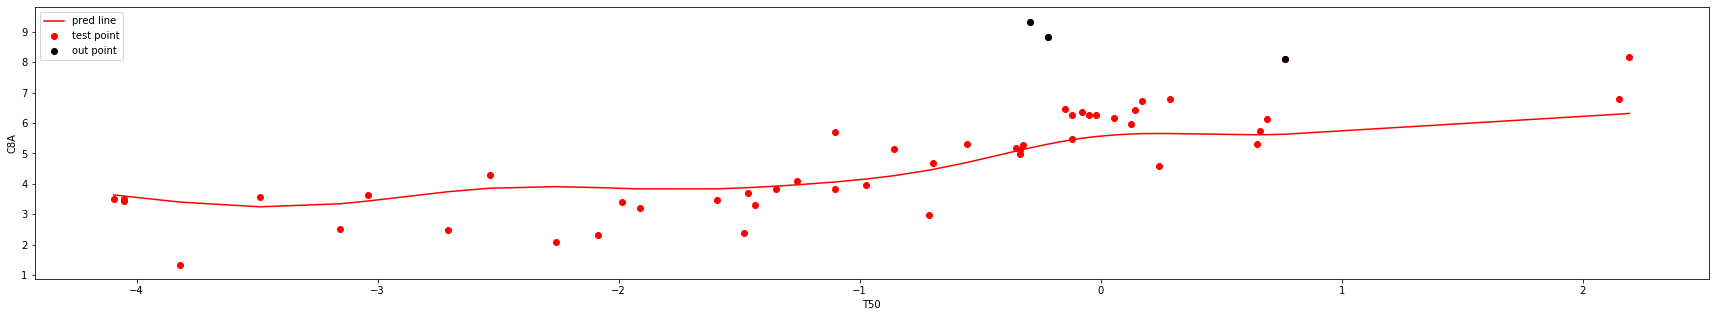

In [22]:
import numpy as np

#add out columns
test_point['out'] = False
test_point.loc[out_index,'out'] = True

#fig
fig = plt.figure(figsize=(30,5))

#sort test point
test_point = test_point.sort_values(by=by_col)

#def out_point
out_point = test_point[test_point['out'] == True]

#y_pred line
plt.plot(test_point[by_col],test_point['y_pred'],label='pred line',color='red')

#test point
plt.scatter(test_point[by_col],test_point[y_name],label='test point',color='red')

#out point
plt.scatter(out_point[by_col],out_point[y_name],label='out point',color='black')

plt.xlabel(by_col)
plt.ylabel(y_name)
plt.legend()
plt.show()

# del_out_point_scores:

In [23]:
print('del_out_point_scores:')
metric(test_point.loc[test_point['out'] == False ,y_name],test_point.loc[test_point['out'] == False ,'y_pred'])

del_out_point_scores:


,R2,RMSE,mean_absolute_error
C8A,0.6904,0.85348,0.654647


# dump model

In [24]:
from sklearn.externals import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']